In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms,utils
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops
import numpy as np

In [ ]:
def imageloading(image):
    img = Image.open(image)
    plt.imshow(img)
    return img
transformed = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224), ])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg = models.vgg19(pretrained = True)
vgg.to(device)
#vgg


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg_list = list(vgg.features.modules())
print(vgg_list)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
def iterator(image, lr, iterations, layer_no):
    image_prp = transformed(image).unsqueeze(0).to(device)
    img_input = Variable(image_prp, requires_grad = True)
    vgg.zero_grad()
    for i in range(iterations):
        dummy_input = img_input
        #print(f'iterations: {i+1} starts')
        for j in range(layer_no):
            #print(f'subiterations: {j+1} starts')
            dummy_input = vgg_list[j+1](dummy_input)
            #print(f'subiterations: {j+1} ends')
        intermediate_loss = dummy_input.norm()
        intermediate_loss.backward()
        img_input.data = img_input.data + img_input.grad.data*lr
        #print(f'iterations: {i+1} ends')
    img_input = img_input.data.squeeze()
    img_input.transpose_(0,1)
    img_input.transpose_(1,2)
    img_input = np.clip(img_input.cpu(),0,1)
    img_input = Image.fromarray(np.uint8(img_input*255))
    return img_input

In [ ]:
def coredeepdream(image, layer, iterations, lr, img_size_reducer,num_octaves):
    #recursion_level = 1 
    if num_octaves>0:
        intermediate_image = image.filter(ImageFilter.UnsharpMask(2))
        if (intermediate_image.size[0]<5   or   intermediate_image.size[1]<5):
            dimensions = intermediate_image.size
        else:
            dimensions = (int(intermediate_image.size[0]/img_size_reducer), int(intermediate_image.size[1]/img_size_reducer))
        intermediate_image = intermediate_image.resize(dimensions, Image.ANTIALIAS)
        intermediate_image = coredeepdream(intermediate_image, layer, iterations,lr, img_size_reducer, num_octaves-1)
        dimensions =( image.size[0], image.size[1])
        intermediate_image = intermediate_image.resize(dimensions, Image.ANTIALIAS)
        image = ImageChops.blend(intermediate_image, image, 0.8)
        #print(f'recursive_level = {recursion_level}, image iterations = {num_octaves}')
        #recursion_level+= 1
    final_image = iterator(image, lr, iterations, layer)
    final_image = final_image.resize(image.size)
    plt.imshow(final_image)
    return final_image
        

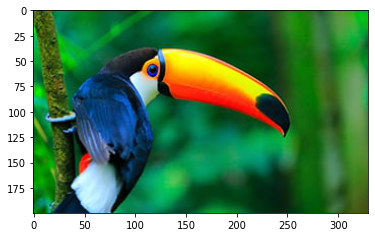

In [ ]:
imaged = imageloading('Toucan.jpg')


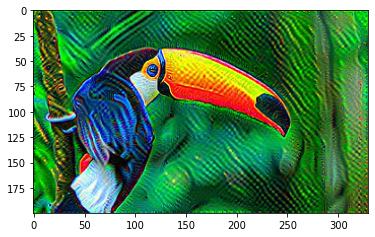

In [ ]:
narak = coredeepdream(imaged,12, 5, 0.1 , 2.5, 16)